# 02 — Model training

## Match Outcome Prediction - Model Training Pipeline

This notebook demonstrates a full machine learning pipeline for predicting football match outcomes.
We will go through all stages:

- Loading and preparing data
- Feature engineering
- Train-test split using `TimeSeriesSplit`
- Oversampling the minority classes with `SMOTE`
- Model training (Random Forest, LightGBM, CatBoost or Stacked ensemble)
- Evaluation (accuracy, macro F1)
- Saving results and visualizations

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

print("Project root added to sys.path:", project_root)


Project root added to sys.path: c:\Users\barte\OneDrive\Pulpit\Studia\ROK III\Semestr 2\football-prediction


In [2]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from src.data_loader import load_data
from src.features import extract_features
from src.constants import FEATURE_COLUMNS
from src.model import train_model, get_model, evaluate_model
from src.metrics import (
    save_confusion_matrix_plot,
    save_classification_report_json,
    save_classification_report_txt
)

import seaborn as sns

In [3]:
input_path = Path.cwd().parent / "data" / "processed" / "model_input.parquet"

df = extract_features(load_data(input_path)).dropna(subset=FEATURE_COLUMNS + ["result"])
X, y = df[FEATURE_COLUMNS], df["result"]

print(f"Data loaded with shape: {X.shape}")
print("Target value distribution:\n", y.value_counts())

Data loaded with shape: (9818, 19)
Target value distribution:
 result
H    4213
A    3129
D    2476
Name: count, dtype: int64


C:\Users\barte\AppData\Local\Temp\ipykernel_13512\4038135526.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


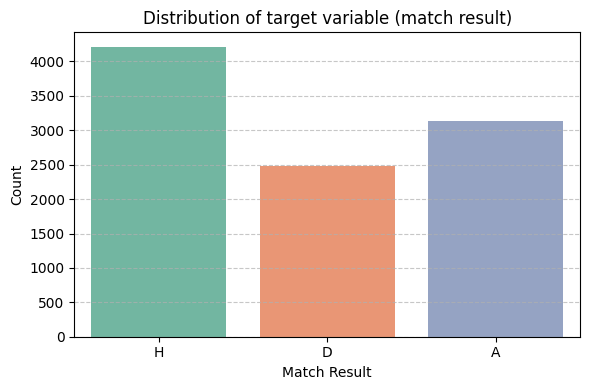

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Distribution of target variable (match result)")
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Time-Aware Train-Test Split

In [ ]:
split_idx = int(len(X) * 0.8)
X_tr, X_te = X.iloc[:split_idx], X.iloc[split_idx:]
y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train size: {len(X_tr)}, Test size: {len(X_te)}")

Train size: 8182, Test size: 1636


### Handle Class Imbalance with SMOTE

In [6]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_tr, y_tr)

print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
 result
H    3522
D    3522
A    3522
Name: count, dtype: int64


C:\Users\barte\AppData\Local\Temp\ipykernel_13512\2303794870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="Set1")


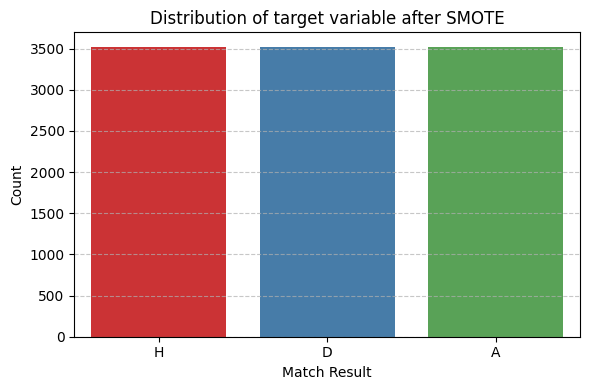

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette="Set1")
plt.title("Distribution of target variable after SMOTE")
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Model Training

Choose model, change algo below to "rf", "lgb", "cat" or "stack".

In [8]:
algo = "rf"

In [9]:
from sklearn.ensemble import StackingClassifier

if algo == "stack":
    base = [
        ("lgb", get_model("lgb")),
        ("cat", get_model("cat")),
        ("rf", get_model("rf")),
    ]
    model = StackingClassifier(
        estimators=base,
        final_estimator=get_model("lgb"),
        passthrough=True,
        n_jobs=-1,
    ).fit(X_resampled, y_resampled)
else:
    model = train_model(X_resampled, y_resampled, algo=algo)


### Evaluation

In [10]:
y_pred = model.predict(X_te)
metrics = evaluate_model(y_te, y_pred, verbose=True)

print(f"✅ Accuracy: {metrics['accuracy']:.3f}")
print(f"✅ Macro F1: {metrics['macro_f1']:.3f}")


              precision    recall  f1-score   support

           A       0.55      0.50      0.53       543
           D       0.30      0.33      0.31       402
           H       0.62      0.63      0.62       691

    accuracy                           0.51      1636
   macro avg       0.49      0.49      0.49      1636
weighted avg       0.52      0.51      0.51      1636

✅ Accuracy: 0.512
✅ Macro F1: 0.487


###  Confusion Matrix Visualization

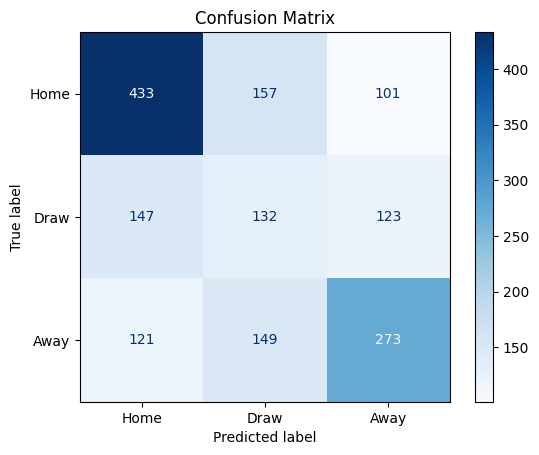

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_te, y_pred, labels=["H", "D", "A"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Home", "Draw", "Away"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Save Model and Metrics

In [12]:
output_dir = Path("output")
output_dir.mkdir(exist_ok=True, parents=True)

joblib.dump(model, output_dir / f"final_model_{algo}.pkl")
(output_dir / "feature_schema.json").write_text(json.dumps(FEATURE_COLUMNS, indent=2))

save_confusion_matrix_plot(y_te, y_pred, output_dir / "confusion_matrix.png")
save_classification_report_txt(y_te, y_pred, output_dir / "report.txt")
save_classification_report_json(y_te, y_pred, output_dir / "metrics.json")

print("✅ Artifacts saved to", output_dir.resolve())


✅ Artifacts saved to C:\Users\barte\OneDrive\Pulpit\Studia\ROK III\Semestr 2\football-prediction\notebooks\output


## Predicting match result

In [13]:
sample_idx = -1
sample_X = X.iloc[[sample_idx]]

In [14]:
sample_X = df.iloc[sample_idx]

home = sample_X["home_team"]
away = sample_X["away_team"]
league = sample_X["league"]
xg_home = sample_X["xG_home"]
xg_away = sample_X["xG_away"]
bookie_home = sample_X["bookie_home"]
bookie_draw = sample_X["bookie_draw"]
bookie_away = sample_X["bookie_away"]
true_result = sample_X["result"]

print(f"League: {league}")
print(f"Match: {home} vs {away}")
print(f"xG: {home} {xg_home:.2f} - {xg_away:.2f} {away}")
print(f"Odds: {home} {bookie_home}, Draw {bookie_draw}, {away} {bookie_away}")
print(f"True result: {true_result}")


League: EPL
Match: Fulham vs Man City
xG: Fulham 2.22 - 2.46 Man City
Odds: Fulham 5.0, Draw 4.2, Man City 1.6
True result: A


In [15]:
import numpy as np

proba = model.predict_proba(sample_X)[0]
# predicted_class = model.predict(sample_X)[0]
predicted_class = model.classes_[np.argmax(proba)]
print(predicted_class)

c:\Users\barte\.conda\envs\footpred\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


TypeError: float() argument must be a string or a real number, not 'Timestamp'

C:\Users\derqu\AppData\Local\Temp\ipykernel_21176\1734882956.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names[::-1], y=proba, palette="Set2")


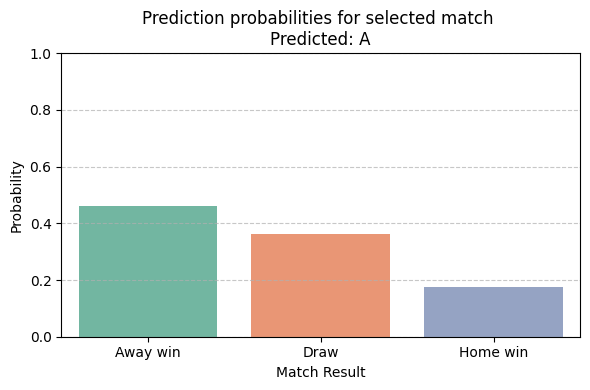

In [ ]:
class_names = ["Home win", "Draw", "Away win"]

plt.figure(figsize=(6, 4))
sns.barplot(x=class_names[::-1], y=proba, palette="Set2")
plt.title(f"Prediction probabilities for selected match \nPredicted: {predicted_class}")
plt.ylabel("Probability")
plt.xlabel("Match Result")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Result

In [ ]:
print(f"League: {league}")
print(f"Match: {home} vs {away}")
print(f"xG: {home} {xg_home:.2f} - {xg_away:.2f} {away}")
print(f"Odds: {home} {bookie_home}, Draw {bookie_draw}, {away} {bookie_away}")
print(f"True result: {true_result}")

print(f"Model prediction: {predicted_class}")
print(f"Prediction probabilities: H={proba[0]:.2f}, D={proba[1]:.2f}, A={proba[2]:.2f}")

League: EPL
Match: Fulham vs Man City
xG: Fulham 2.22 - 2.46 Man City
Odds: Fulham 5.0, Draw 4.2, Man City 1.6
True result: A
Model prediction: A
Prediction probabilities: H=0.46, D=0.36, A=0.18
